# Improved WGAN with Gradient Penalty on MNIST

Wasserstein distance, also known as the Earth Mover's distance, between two distributions is intuitively defined as the minimum amount of "probability mass" needed to be moved for one distribution to be turned into another distribution. Its advantage over JS divergence in training GANs is that the gradient does not vanish when the generated distribution has no or little overlap with the target distribution. [1] introduced the Wasserstein distance and showed a way to train GAN models that minimizes the Wasserstein distance via weight clipping. However, [2] showed that weight clipping makes the training slower and proposed a simpler loss: $\mathbf{E}_{(z, y)\sim \Pi(P_{z}, P_{label})}\big[D_{\theta_d}(G_{\theta_g}(z), y)\big] - \mathbf{E}_{(x, y)\sim P_{(x, correct\ label)}}\big[D_{\theta_d}(x, y)\big] + \lambda\big(\Vert\nabla_{\hat{x}}D_{\theta_d}(\hat{x}, y)\Vert_2-1\big)^2$, where each $\hat{x}$ is a random point on the interpolation between a randomly picked real data point (image) and a randomly picked fake data point (image).

[1] Martin Arjovsky, Soumith Chintala, Léon Bottou, _Wasserstein GAN_, 	arXiv:1701.07875 (2017).

[2] Ishaan Gulrajani, Faruk Ahmed, Martin Arjovsky, Vincent Dumoulin, Aaron Courville, _Improved Training of Wasserstein GANs_, arXiv:1704.00028 (2017)

In [1]:
import tensorflow as tf
import numpy as np
from sklearn import datasets
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
from tensorflow.python import debug as tf_debug
import tensorflow.contrib as tc
import tensorflow.contrib.layers as tcl
import os

%matplotlib inline

/home/rluo/anaconda3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def leaky_relu(x, alpha=0.1):
    return tf.maximum(tf.minimum(0.0, alpha * x), x)

In [3]:
def gen_net(z, hidden_dims, out_dim):
    with tf.variable_scope('gen', reuse=tf.AUTO_REUSE) as vs:
        fc = z
        for dim in hidden_dims:
            fc = tcl.fully_connected(
                    fc, dim,
                    weights_initializer=tf.random_normal_initializer(stddev=0.1),
                    weights_regularizer=tc.layers.l2_regularizer(2.5e-5),
                    activation_fn=tcl.batch_norm
            )
            fc = leaky_relu(fc)
        fc = tcl.fully_connected(
            fc, out_dim,
            weights_initializer=tf.random_normal_initializer(stddev=0.1),
            weights_regularizer=tc.layers.l2_regularizer(2.5e-5),
            activation_fn=tf.sigmoid
        )
        
        return fc

In [4]:
def crit_net(x):
    with tf.variable_scope('critic', reuse=tf.AUTO_REUSE) as vs:
        bs = tf.shape(x)[0]
        x = tf.reshape(x, [bs, 28, 28, 1])
        conv1 = tc.layers.convolution2d(
            x, 256, [4, 4], [2, 2],
            weights_initializer=tf.random_normal_initializer(stddev=0.1),
            activation_fn=tcl.layer_norm
        )
        conv1 = leaky_relu(conv1)
        # conv1 = tcl.max_pool2d(conv1, [2, 2])
        conv2 = tc.layers.convolution2d(
            conv1, 128, [4, 4], [2, 2],
            weights_initializer=tf.random_normal_initializer(stddev=0.1),
            activation_fn=tcl.layer_norm
        )
        conv2 = leaky_relu(conv2)
        # conv2 = tcl.max_pool2d(conv2, [2, 2])
        conv2 = tcl.flatten(conv2)
        fc1 = tc.layers.fully_connected(
            conv2, 128,
            weights_initializer=tf.random_normal_initializer(stddev=0.1),
            activation_fn=tcl.layer_norm
        )
        fc1 = tf.nn.dropout(leaky_relu(tc.layers.layer_norm(fc1)), 0.95)
        fc2 = tc.layers.fully_connected(
            fc1, 64,
            weights_initializer=tf.random_normal_initializer(stddev=0.1),
            activation_fn=tcl.layer_norm
        )
        fc2 = tf.nn.dropout(leaky_relu(tc.layers.layer_norm(fc2)), 0.95)
        fc3 = tc.layers.fully_connected(
            fc2, 16,
            weights_initializer=tf.random_normal_initializer(stddev=0.1),
            activation_fn=tcl.layer_norm
        )
        fc3 = leaky_relu(fc3)
        fc3 = tc.layers.fully_connected(fc3, 1, activation_fn=tf.sigmoid)
        
        return fc3

In [5]:
z_dim = 100
gen_hidden_dims = [256, 512, 512, 512]

batch_size = 275

with tf.device('/device:GPU:1'):


    ## Place holder for the real images
    x = tf.placeholder(tf.float32, [batch_size, 28 * 28], name='x')
    ## Place holder for the noise
    z = tf.placeholder(tf.float32, [batch_size, z_dim], name='z')
    out_gen = gen_net(z, gen_hidden_dims, 28 * 28)
    # Define the ops and weights for Discriminator
    y_data = crit_net(x)
    y_fake = crit_net(out_gen)

    eps = tf.random_uniform([batch_size, 1])
    x_hat = eps * x + (1 - eps) * out_gen
    y_mid = crit_net(x_hat)

    lam = 10
    gradients = tf.gradients(y_mid, x_hat)[0]
    crit_loss = (tf.reduce_mean(y_fake)
                 - tf.reduce_mean(y_data)
                 + lam * tf.reduce_mean(tf.square(tf.norm(gradients, axis=1) - 1))
                )
    
    gen_loss = -tf.reduce_mean(y_fake)

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        c_adam = tf.train.AdamOptimizer(learning_rate=1e-4, beta1=0.1, beta2=0.95)\
            .minimize(crit_loss, var_list=[var for var in tf.global_variables() if 'crit' in var.name])
        g_adam = tf.train.AdamOptimizer(learning_rate=1e-4, beta1=0.1, beta2=0.95)\
            .minimize(gen_loss, var_list=[var for var in tf.global_variables() if 'gen' in var.name])
    
    init = tf.global_variables_initializer()

saver = tf.train.Saver(max_to_keep=None)

In [6]:
# Read the MNIST datadet
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [ ]:
costc = []
costg = []
pdata_list = []
pfake_list = []

with tf.Session() as sess:
    sess.run(init)
    
    epoch = 0
    while mnist.train.epochs_completed <= 200:
        
        for j in range(5):
            batch_x, _ = mnist.train.next_batch(batch_size)
            x_value = batch_x
            z_value = np.random.uniform(-1, 1, size=(batch_size, z_dim)).astype(np.float32)
            sess.run(c_adam, feed_dict={x:batch_x, z:z_value})

        z_value2 = np.random.uniform(-1, 1, size=(batch_size, z_dim)).astype(np.float32)
        sess.run(g_adam, feed_dict={x:x_value, z:z_value2})

        crit_cost, gen_cost = sess.run([crit_loss, gen_loss], feed_dict={x:x_value, z:z_value})
        pdata, pfake = sess.run([tf.reduce_mean(y_data), tf.reduce_mean(y_fake)],
                                feed_dict={x:x_value, z:z_value2})

        costc.append(crit_cost)
        costg.append(gen_cost)
        pdata_list.append(pdata)
        pfake_list.append(pfake)
        
        if mnist.train.epochs_completed > epoch and epoch % 10 == 0:
            z_sample = np.random.uniform(-1, 1, size=(batch_size, z_dim)).astype(np.float32)
            out_val_img = sess.run(out_gen, feed_dict={z: z_sample})
            for k in range(16):
                plt.subplot(4, 4, k + 1)
                image = np.reshape(out_val_img[k], (28,28))
                plt.imshow(image, cmap='gray')
            plt.show()
            
            print(f'epoch: {epoch}')
            saver.save(sess, f'wgan/wgan_epoch{epoch}.chkp')
            
        epoch = mnist.train.epochs_completed

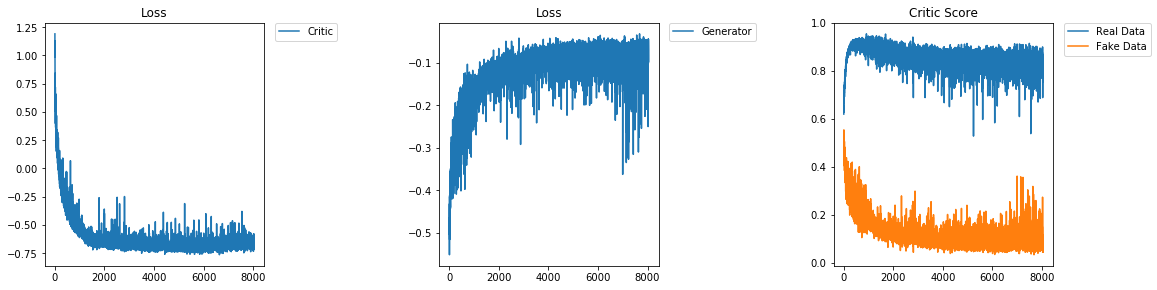

In [9]:
plt.figure(figsize=(20,5))
plt.subplot(131)
plt.plot(costc, label='Critic')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Loss')
plt.subplot(132)
plt.plot(costg, label='Generator')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Loss')
plt.subplot(133)
plt.plot(pdata_list, label='Real Data')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.plot(pfake_list, label='Fake Data')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Critic Score')
plt.subplots_adjust(left=0.2, wspace=0.8, top=0.8)
plt.show()

INFO:tensorflow:Restoring parameters from wgan/wgan_epoch200.chkp


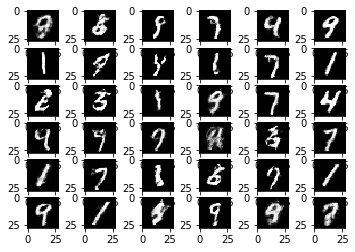

In [13]:
with tf.Session() as sess:
    sess.run(init)
    saver.restore(sess, 'wgan/wgan_epoch200.chkp')

    z_sample = np.random.uniform(-1, 1, size=(batch_size, z_dim)).astype(np.float32)
    out_val_img = sess.run(out_gen, feed_dict={z: z_sample})
    for k in range(36):
        plt.subplot(6, 6, k + 1)
        image = np.reshape(out_val_img[k], (28,28))
        plt.imshow(image, cmap='gray')
    plt.show()